In [26]:
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import pandas as pd
import math

#Import satellite altimetry data:

sealevel = xr.open_dataset("D:/Data/Satellite_data/Altimetry/cmems.nc") 

In [27]:
#Converte daily data to seasonal mean data:

sealevel_selection = sealevel.groupby('time.season').mean('time', skipna=True)
sealevel_season = sealevel_selection.sel(season="JJA")
adt = sealevel_season.adt 

Calculate the geostrophic current:

u= -  g/f  *∂ADT/∂y			 

v=   g/f  *∂ADT/∂x			

The equation includes: f [𝑟𝑎𝑑/s] as the Coriolis parameter, g [𝑚/𝑠^2] as the acceleration of gravity, dx, dy are the distance between two consecutive grid nodes in the zonal and meridional directions and ADT as the Absolute Dynamic Topography.

In [75]:
lon = adt.longitude 
lat = adt.latitude 
lon, lat = np.meshgrid(lon,lat)

g = 9.81
#Calculation of the angular velocity: 

omega = 2*math.pi/(24*60*60)

In [29]:
#Calculation of the Coriolis frequency: 

f = 2*omega*np.sin(np.radians(lat))
f = f[:-1,:-1]

In [30]:
#Calculation of the length of dx and dy. The data has an spatial revolution of 1/4 of 1 degree=111 km:

dx=0.25*111000 
dy=0.25*111000

In [31]:
##Calculation of the height diffrence between neighbour ADTs: ∂ADT

adt_delta_x = (adt[:,:-1]-adt[:,1:].values)
adt_delta_x = adt_delta_x[:-1,:]

adt_delta_y = (adt[:-1,:]-adt[1:,:].values)
adt_delta_y = adt_delta_y[:,:-1]

In [32]:
# Calculation of the u- and v-component of the Geostrophic current:

u = (g/f) * (adt_delta_x/dx)
v = (g/f) * (adt_delta_y/dy)

In [83]:
#Calculation of the speed and direction of the geostrophic current:

sp = (0.5*(u**2 + v**2)**0.5)*100
direction = np.arctan2(u,v)

#Same shape of lat,lon and sp:

lat= lat[1:,:-1]
lon= lon[1:,:-1]

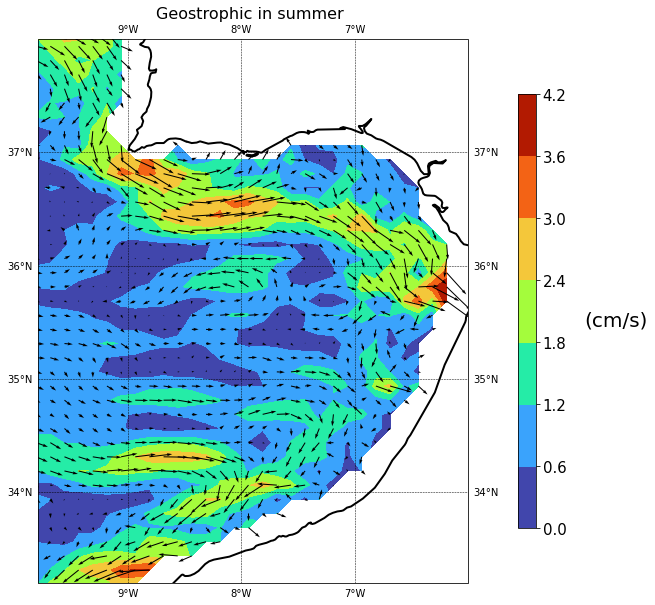

In [92]:
#Visualisation of the geostrophic current:

fig = plt.figure(figsize=(18,10)) 
ax = plt.axes(projection=ccrs.PlateCarree()) 
ax.set_extent([-9.8,-6,33.2,38]) 
ax.coastlines(resolution="10m",linewidth=2) 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='black', linestyle='--') 
gl.xlocator = mticker.FixedLocator([-7,-8,-9]) 
gl.ylocator = mticker.FixedLocator([34,35,36,37])

a=adt[:-1,:-1]*100
r = np.arange(0.0015,0.03,0.0001)

plt.contourf(lon, lat, sp, transform=ccrs.PlateCarree(),cmap=plt.cm.turbo) 
plt.title('Geostrophic in summer ', size=16) 
cb = plt.colorbar(ax=ax, orientation="vertical", pad=0.05, aspect=25, shrink=0.8) 
cb.set_label("(cm/s)",size=20,rotation=0,labelpad=50) 
cb.ax.tick_params(labelsize=15)

plt.quiver(lon, lat, v, -u, scale=1)